In [ ]:
##Here we expand numbers in p-adic

In [158]:
import numpy as np
from fractions import Fraction

# ------------------------------------------------------------
# Extended Euclidean Algorithm
# ------------------------------------------------------------
def Extended_Euclidean_Recursive(a, b):
    if b == 0:
        return a, 1, 0
    g, x1, y1 = Extended_Euclidean_Recursive(b, a % b)
    return g, y1, x1 - (a // b) * y1

# ------------------------------------------------------------
# p-adic valuation
# ------------------------------------------------------------
def v_p(n, p):
    n = abs(n)
    k = 0
    while n % p == 0 and n != 0:
        n //= p
        k += 1
    return k

# ------------------------------------------------------------
# Positive p-adic expansion (handles denominators divisible by p)
# digits are least-significant first
# ------------------------------------------------------------
def p_expansion_positive(r, s, p, n, *, report=True):
    """
    Compute the p-adic expansion digits of x = r/s (r,s>0) up to n digits.
    Handles denominators divisible by p. If report=True, prints any valuation shift.
    """
    # factor out powers of p from r and s
    v_r = v_p(r, p)
    v_s = v_p(s, p)
    shift = v_r - v_s            # overall power of p (v_p(x))
    r_ = r // (p ** v_r)
    s_ = s // (p ** v_s)

    # s_ now coprime to p
    x = Fraction(r_, s_)
    digits = []
    s_partial = Fraction(0, 1)
    f_prev = x

    for i in range(n):
        r_i = f_prev.numerator
        s_i = f_prev.denominator

        g, u, _ = Extended_Euclidean_Recursive(s_i % p, p)
        if g != 1:
            raise ValueError("Denominator not invertible mod p.")
        u %= p

        # a_i = ((r_i mod p)*(s_i^{-1} mod p)) mod p
        a_i = ((r_i % p) * u) % p
        digits.append(a_i)

        # update next fractional term
        s_partial = s_partial + Fraction(a_i * (p ** i), 1)
        f_prev = (x - s_partial) / (p ** (i + 1))

    # apply valuation shift and REPORT it
    if shift > 0:
        if report:
            print(f"[shift] v_p(x) = {shift} ⇒ prepending {shift} zero digit(s).")
        digits = ([0] * shift + digits)[:n]
    elif shift < 0:
        if report:
            print(f"[shift] v_p(x) = {shift} ⇒ series starts at power p^{shift} (negative index).")

    return digits

# ------------------------------------------------------------
# General p-adic expansion with correct negative handling
# ------------------------------------------------------------
def p_expansion(r, s, p, n):
    if r == 0:
        return [0]*n

    neg = (r < 0) ^ (s < 0)
    r_abs, s_abs = abs(r), abs(s)

    pos = p_expansion_positive(r_abs, s_abs, p, n)
    if not neg:
        return pos

    # find first nonzero digit index k
    k = None
    for i, d in enumerate(pos):
        if d % p != 0:
            k = i
            break

    neg_digits = [0]*n
    if k is None:
        # |x| ≡ 0 mod p^n ⇒ -x also ≡ 0 mod p^n
        return neg_digits

    for i in range(n):
        if i < k:
            neg_digits[i] = 0                         # *** FIX: was p-1
        elif i == k:
            neg_digits[i] = (p - pos[i]) % p
        else:
            neg_digits[i] = (p - 1 - pos[i]) % p

    return neg_digits


[shift] v_p(x) = 1 ⇒ prepending 1 zero digit(s).


[0, 1, 0, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 1]

In [ ]:
## Here we find the corresponding euclidean number of a p adic expansion

In [283]:
def p_pow_frac(p: int, e: int) -> Fraction:
    """Exact p^e as Fraction (supports negative e)."""
    return Fraction(p**e, 1) if e >= 0 else Fraction(1, p**(-e))

def normalize_digits(digs, p, order: str):
    """
    Ensure digits are least-significant-first and validated.
    order: 'lsf' (least-significant-first) or 'msf' (most-significant-first).
    """
    if order not in ("lsf", "msf"):
        raise ValueError("order must be 'lsf' or 'msf'")
    if any((d < 0 or d >= p) for d in digs):
        raise ValueError("All digits must be in [0, p-1].")
    return list(digs) if order == "lsf" else list(reversed(digs))

def p_adic_to_euclidean(prefix, cycle, p, start_power=0, order="lsf") -> Fraction:
    """
    Convert a p-adic expansion with arbitrary start power r to an exact Euclidean Fraction.

    Parameters
    ----------
    prefix : list[int]
        finite non-repeating digits (a_0, ..., a_{k-1})
    cycle  : list[int]
        repeating block digits (b_0, ..., b_{m-1}); empty => finite expansion only
    p : int
        prime base
    start_power : int
        r, the exponent of the first prefix digit (series starts at p^r)
    order : 'lsf' or 'msf'
        whether `prefix` and `cycle` are given least- or most-significant-first

    Returns
    -------
    Fraction : exact rational value
    """
    # normalize to least-significant-first
    prefix = normalize_digits(prefix, p, order)
    cycle  = normalize_digits(cycle,  p, order)

    k = len(prefix)
    m = len(cycle)

    # A0 = sum_{i=0}^{k-1} a_i p^i  (exact)
    A0 = Fraction(0, 1)
    for i, a in enumerate(prefix):
        if a:
            A0 += Fraction(a, 1) * p_pow_frac(p, i)

    if m == 0:
        # finite expansion: x = p^r * A0
        return p_pow_frac(p, start_power) * A0

    # B0 = sum_{j=0}^{m-1} b_j p^j  (exact)
    B0 = Fraction(0, 1)
    for j, b in enumerate(cycle):
        if b:
            B0 += Fraction(b, 1) * p_pow_frac(p, j)

    # x = p^r * ( A0 + p^k * B0 / (1 - p^m) )
    numer_tail = p_pow_frac(p, k) * B0          # p^k * B0
    geom = Fraction(1, 1 - (p**m))              # 1/(1 - p^m) exact (integer denom)
    inner = A0 + numer_tail * geom
    x = p_pow_frac(p, start_power) * inner
    return x

Fraction(-5535, 728)

In [ ]:
## Here we create a p-adic straight line

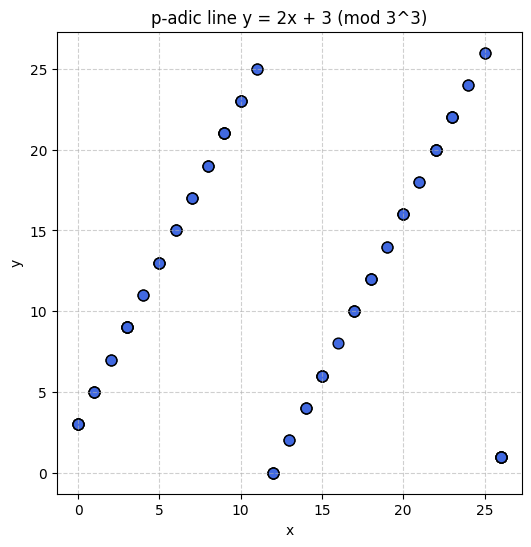

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def p_adic_line(a, b, p, n):
    precision = p ** n
    mod = precision  
    num_x = 100   
    dim = n     

    # random base-p digits
    x_c = np.random.randint(0, p, size=(num_x, dim))

    # compute p-powers
    powers = p ** np.arange(x_c.shape[1])

    # convert base-p digits to integers
    x_v = np.sum(x_c * powers, axis=1)

    # reduce mod p^n
    x = np.mod(x_v, mod)
    y = np.mod(a * x + b, mod)

    # plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, color='royalblue', edgecolor='black', s=60)
    plt.title(f"p-adic line y = {a}x + {b} (mod {p}^{n})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
p_adic_line(a=2, b=3, p=3, n=3)
